In [1]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import numpy as np
import plotly.graph_objects as go

In [2]:
df = pd.read_pickle('../data/all_enron_emails_preprocessed.pkl')

In [3]:
df.drop(['responses', 'is_reply'], axis=1, inplace=True)
df.fillna(0, inplace=True)

In [4]:
X = df.drop(columns=['answered'])
y = df['answered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [6]:
# READ THE MODELS
rf_model = joblib.load('../data/Random Forest_model.pkl')
xgb_model = joblib.load('../data/XGBoost_model.pkl')
gb_model = joblib.load('../data/Gradient Boosting_model.pkl')

In [7]:
voting_classifier = VotingClassifier(estimators=[('rf', rf_model), ('gb', gb_model), ('xgb', xgb_model)], voting='soft')
voting_classifier.fit(X_train, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(min_samples_split=6,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categori...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [8]:
rf_predict = rf_model.predict(X_test)
gb_predict = gb_model.predict(X_test)
xgb_predict = xgb_model.predict(X_test)
voting_predict = voting_classifier.predict(X_test)

In [9]:
# Create the df with the features and the importance
features = X.columns
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

importances = pd.DataFrame({'feature': features, 'rf_importance': rf_importances, 'gb_importance': gb_importances, 'xgb_importance': xgb_importances})
importances['mean_importance'] = importances[['rf_importance', 'gb_importance', 'xgb_importance']].mean(axis=1)
importances = importances.sort_values(by='mean_importance', ascending=False)
# importances = importances[importances['mean_importance'] > 1e-3]

importances_filtered = importances[
    (importances['feature'].isin(['day_week', 'number_of_receivers', 'length_num', 'hour', 'minute', 'second', 'thanks', 'sorry', 'want'])) |
    (importances['mean_importance'] > 1e-3) |
    (importances['rf_importance'] > 2e-2) | 
    (importances['xgb_importance'] > 2e-2) |
    (importances['gb_importance'] > 2e-2)
]

importances_filtered

,feature,rf_importance,gb_importance,xgb_importance,mean_importance
2,length_num,0.050403,0.266442,0.006907,0.107917
262,cc,0.039708,0.220137,0.012392,0.090745
702,forwarded,0.020269,0.212747,0.024163,0.085726
1575,second,0.023978,0.048964,0.002127,0.025023
135,attached,0.015757,0.038282,0.008131,0.020723
...,...,...,...,...,...
445,debra,0.000478,0.000000,0.002553,0.001011
915,jeff,0.002451,0.000000,0.000575,0.001009
18,actually,0.000598,0.000522,0.001880,0.001000
1923,want,0.002155,0.000000,0.000404,0.000853


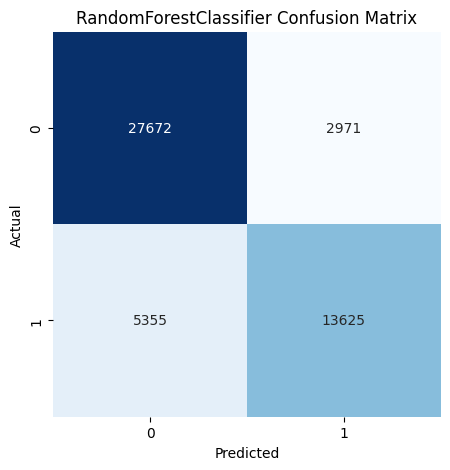

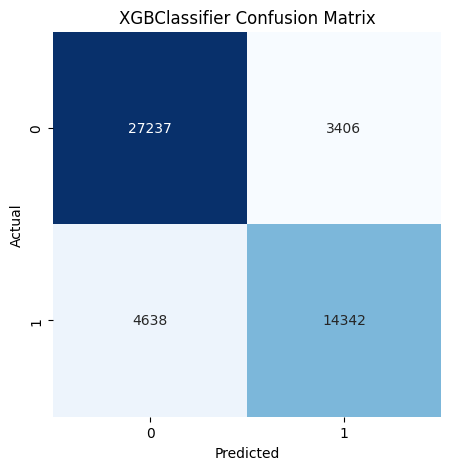

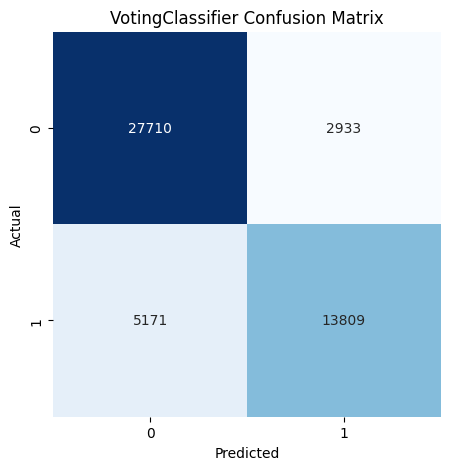

In [10]:
for classifier in [rf_model, xgb_model, voting_classifier]:
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title(f'{classifier.__class__.__name__} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{classifier.__class__.__name__}_confusion_matrx.png')
    plt.show()

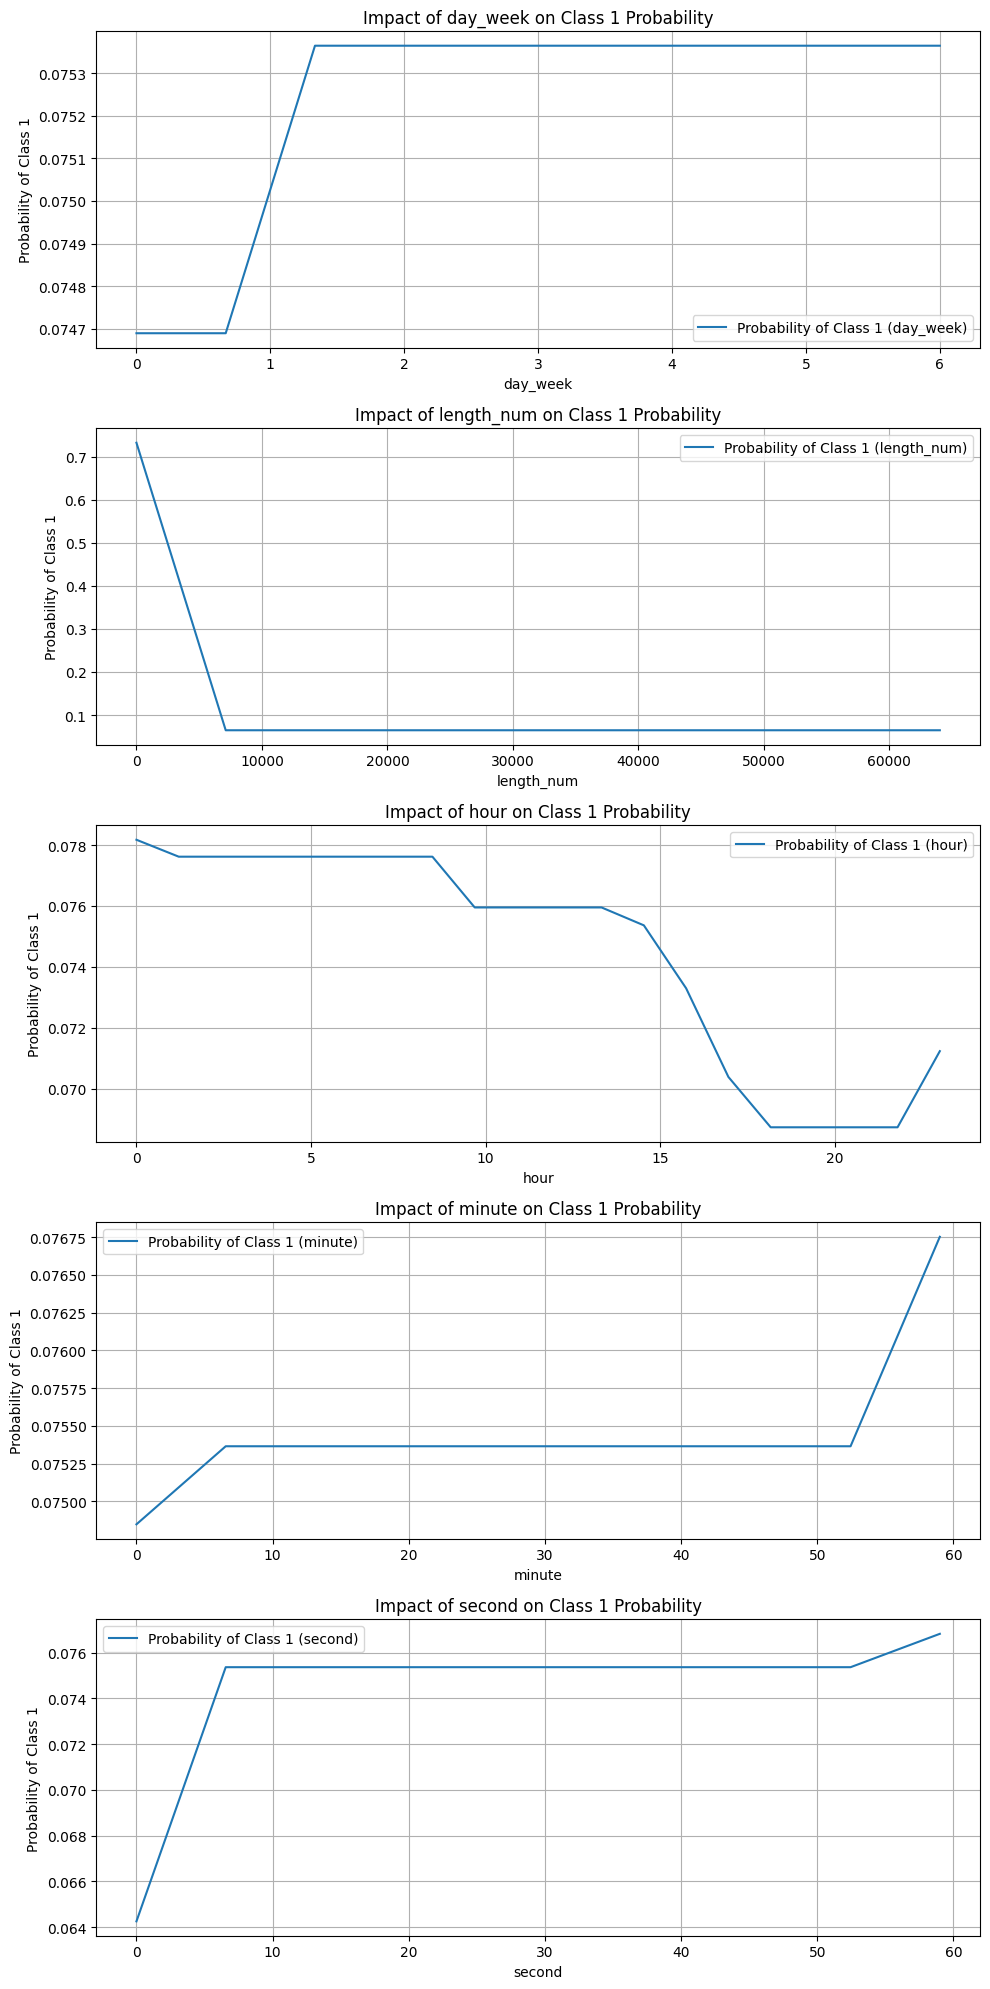

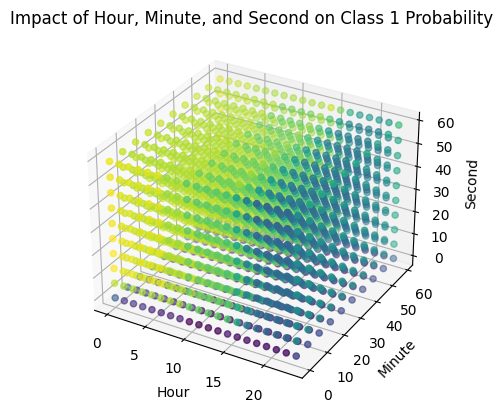

The best value for day_week to maximize the probability of Class 1 is: 1.3333333333333333
The best value for length_num to maximize the probability of Class 1 is: 0.0
The best value for hour to maximize the probability of Class 1 is: 0.0
The best value for minute to maximize the probability of Class 1 is: 59.0
The best value for second to maximize the probability of Class 1 is: 59.0
The best combination of hour, minute, and second to maximize the probability of Class 1 is: [ 0.          0.         13.11111111]


In [11]:
# Assuming X_test is already defined and is a DataFrame
# Ensure 'X_test' is a DataFrame
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=features)

# Function to get the probability of the positive class for varying values of features
def evaluate_feature_impact(feature_names, model, base_instance, feature_ranges):
    probabilities = []
    # Generate combinations of feature values
    feature_combinations = np.array(np.meshgrid(*feature_ranges)).T.reshape(-1, len(feature_names))
    for values in feature_combinations:
        temp_instance = base_instance.copy()
        for i, feature in enumerate(feature_names):
            temp_instance[feature] = values[i]
        probability = model.predict_proba([temp_instance])[0, 1]  # Probability of the positive class
        probabilities.append(probability)
    return feature_combinations, probabilities

# Select a base instance from X_test, e.g., the first instance
base_instance = X_test.iloc[0].copy()

# Define the range of values for each feature to evaluate with more granularity for 'hour'
feature_ranges = {
    'day_week': np.linspace(X_test['day_week'].min(), X_test['day_week'].max(), 10),
    'length_num': np.linspace(X_test['length_num'].min(), X_test['length_num'].max(), 10),
    'hour': np.linspace(X_test['hour'].min(), X_test['hour'].max(), 20),  # More granular
    'minute': np.linspace(X_test['minute'].min(), X_test['minute'].max(), 10),
    'second': np.linspace(X_test['second'].min(), X_test['second'].max(), 10),
}

# Evaluate each feature independently and collect data for plotting
individual_results = {}
for feature_name, feature_range in feature_ranges.items():
    feature_combinations, probabilities = evaluate_feature_impact([feature_name], voting_classifier, base_instance, [feature_range])
    best_value = feature_combinations[np.argmax(probabilities)]
    individual_results[feature_name] = (feature_range, probabilities, best_value[0])

# Evaluate the combined effect of hour, minute, and second
combined_features = ['hour', 'minute', 'second']
combined_ranges = [feature_ranges[feature] for feature in combined_features]
feature_combinations, probabilities = evaluate_feature_impact(combined_features, voting_classifier, base_instance, combined_ranges)
best_combination = feature_combinations[np.argmax(probabilities)]
combined_results = (feature_combinations, probabilities, best_combination)

# Plot the results for individual features
fig, axes = plt.subplots(len(individual_results), 1, figsize=(10, 20))

for i, (feature_name, (feature_range, probabilities, best_value)) in enumerate(individual_results.items()):
    ax = axes[i]
    ax.plot(feature_range, probabilities, label=f'Probability of Class 1 ({feature_name})')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Probability of Class 1')
    ax.set_title(f'Impact of {feature_name} on Class 1 Probability')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig('combined_features.png')
plt.show()

# Plot the results for the combined features
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(combined_results[0][:, 0], combined_results[0][:, 1], combined_results[0][:, 2], c=combined_results[1], cmap='viridis')
ax.set_xlabel('Hour')
ax.set_ylabel('Minute')
ax.set_zlabel('Second')
plt.title('Impact of Hour, Minute, and Second on Class 1 Probability')
plt.savefig('combined_time.png')
plt.show()

# Create an interactive 3D plot for the combined features using plotly
fig = go.Figure(data=[go.Scatter3d(
    x=combined_results[0][:, 0],
    y=combined_results[0][:, 1],
    z=combined_results[0][:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=combined_results[1],
        colorscale='Viridis',
        colorbar=dict(title='Probability of Class 1'),
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Hour',
        yaxis_title='Minute',
        zaxis_title='Second'
    ),
    title='Impact of Hour, Minute, and Second on Class 1 Probability'
)

fig.show()

# Print best values for each feature and the combined features
for feature_name, (_, _, best_value) in individual_results.items():
    print(f"The best value for {feature_name} to maximize the probability of Class 1 is: {best_value}")

print(f"The best combination of hour, minute, and second to maximize the probability of Class 1 is: {combined_results[2]}")


In [12]:
# import shap
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# if isinstance(X_test, np.ndarray):
#     X_test = pd.DataFrame(X_test, columns=features)

# # Exclude non-text features
# non_text_features = ['day_week', 'length_num', 'hour', 'minute', 'second']
# X_test_text_only = X_test.drop(non_text_features, axis=1)

# import shap

# # Initialize SHAP explainer for each model in the voting classifier
# explainers = [shap.TreeExplainer(model[1]) for model in voting_classifier.estimators]

# # Compute SHAP values for each model
# shap_values = [explainer.shap_values(X_test_text_only) for explainer in explainers]

# # Average SHAP values across models
# shap_values_combined = np.mean(shap_values, axis=0)

# # Plot the summary plot for the SHAP values
# shap.summary_plot(shap_values_combined, X_test_text_only, plot_type="bar")

# # Get feature names from the tfidf_vectorizer
# feature_names = tfidf_vectorizer.get_feature_names_out()

# # Convert SHAP values to a DataFrame
# shap_df = pd.DataFrame(shap_values_combined, columns=feature_names)

# # Calculate mean absolute SHAP values to determine overall feature impact
# mean_shap_values = shap_df.abs().mean(axis=0)

# # Sort by mean absolute SHAP values
# sorted_shap_values = mean_shap_values.sort_values(ascending=False)

# # Identify top positive and negative contributors
# top_positive_contributors = sorted_shap_values.head(50)
# top_negative_contributors = sorted_shap_values.tail(50)

# # Print the results
# print("Top Positive Contributors (Words with High Impact on Class 1 Probability):")
# print(top_positive_contributors)

# print("\nTop Negative Contributors (Words with High Impact on Class 0 Probability):")
# print(top_negative_contributors)


In [13]:
# Save the voiting classifier
joblib.dump(voting_classifier, 'voting_classifier.pkl')

['voting_classifier.pkl']

In [14]:
# Save the importances dataframe
importances_filtered.to_csv('importances.csv')